## Question	7 [Discriminative	vs	Generative	Models,	25	Marks]

### I. Load	 Task1E_train.csv and	 Task1E_test.csv as	 well	 as	 the	 Bayesian classifier	(BC)	and	logistic	regression	(LR)	codes	from	Activities	2	and	3	in	Module	3.

In [1]:
# Load libraries
library(ggplot2)
library(reshape2)
library(mvtnorm) # generates multivariate Gaussian sampels and calculate the densities

In [2]:
# Load data
data7.train <- read.csv("./Task1E_train.csv")
data7.test <- read.csv("./Task1E_test.csv")

In [3]:
# Bayesian classifier (BC)
# refers to tutorial code
BayesianClassifier <- function(train.data,train.label,test.data){
    
    # Class probabilities:
    p0.hat <- sum(train.label==1)/nrow(train.data) # total number of samples in class 0 divided by the total nmber of training data
    p1.hat <- sum(train.label==-1)/nrow(train.data) # or simply 1 - p1.hat

    # Class means:
    mu0.hat <- colMeans(train.data[train.label==1,])
    mu1.hat <- colMeans(train.data[train.label==-1,])
    
    # class covariance matrices:
    sigma0.hat <- var(train.data[train.label==1,])
    sigma1.hat <- var(train.data[train.label==-1,])
    
    # shared covariance matrix:
    sigma.hat <- p0.hat * sigma0.hat + p1.hat * sigma1.hat 
    
    # calculate posteriors:
    posterior0 <- p0.hat*dmvnorm(x=train.data, mean=mu0.hat, sigma=sigma.hat)
    posterior1 <- p1.hat*dmvnorm(x=train.data, mean=mu1.hat, sigma=sigma.hat)
    
    # Predict on testing data
    test.predict <- ifelse(p0.hat*dmvnorm(x=test.data, mean=mu0.hat, sigma=sigma.hat) > p1.hat*dmvnorm(x=test.data, mean=mu1.hat, sigma=sigma.hat), 1, -1)

    return(test.predict)
    }

In [4]:
# Logistic Regression (LR)
# refers to tutorial code

LogisticRegresson <- function(train.data,train.label,test.data){
 
    # auxiliary function that predicts class labels
    predict <- function(w, X, c0, c1){
    sig <- sigmoid(w, X)
    return(ifelse(sig>0.5, c1,c0))
    }
    
    # auxiliary function that calculate a cost function
    cost <- function (w, X, T, c0){
    sig <- sigmoid(w, X)
    return(sum(ifelse(T==c0, 1-sig, sig)))
    }
    
    # Sigmoid function (=p(C1|X))
    sigmoid <- function(w, x){
    return(1.0/(1.0+exp(-w%*%t(cbind(1,x)))))    
    }
    
    
    # Initializations
    c0 <- 1; c1 <- -1
    tau.max <- 1000 # maximum number of iterations
    eta <- 0.01 # learning rate
    epsilon <- 0.01 # a threshold on the cost (to terminate the process)
    tau <- 1 # iteration counter
    terminate <- FALSE

    ## Just a few name/type conversion to make the rest of the code easy to follow
    X <- as.matrix(train.data) # rename just for conviniance
    T <- ifelse(train.label==c0,0,1) # rename just for conviniance

    W <- matrix(,nrow=tau.max, ncol=(ncol(X)+1)) # to be used to store the estimated coefficients
    W[1,] <- runif(ncol(W)) # initial weight (any better idea?)

    # project data using the sigmoid function (just for convenient)
    Y <- sigmoid(W[1,],X)

    costs <- data.frame('tau'=1:tau.max)  # to be used to trace the cost in each iteration
    costs[1, 'cost'] <- cost(W[1,],X,T, c0)
    
    
    while(!terminate){
    # check termination criteria:
    terminate <- tau >= tau.max | cost(W[tau,],X,T, c0)<=epsilon
    
    # shuffle data:
    train.index <- sample(1:nrow(train.data), nrow(train.data), replace = FALSE)
    X <- X[train.index,]
    T <- T[train.index]
    
    # for each datapoint:
    for (i in 1:nrow(train.data)){
        # check termination criteria:
        if (tau >= tau.max | cost(W[tau,],X,T, c0) <=epsilon) {terminate<-TRUE;break}
        
        Y <- sigmoid(W[tau,],X)
            
        # Update the weights
        W[(tau+1),] <- W[tau,] - eta * (Y[i]-T[i]) * cbind(1, t(X[i,]))
        
        # record the cost:
        costs[(tau+1), 'cost'] <- cost(W[tau,],X,T, c0)
        
        # update the counter:
        tau <- tau + 1
        
        # decrease learning rate:
        eta = eta * 0.999
        }
    }
    # Done!
    costs <- costs[1:tau, ] # remove the NaN tail of the vector (in case of early stopping)

    # the  final result is:
    w <- W[tau,]
    
    return(predict(w,test.data,c0,c1))
    
    } 

### II. Using	 the	 first	 5 data	 points	 from	 the	 training	 set,	 train	 a	 BC	 and	 a	 LR	model,	and	compute	their	test	errors.	In	a	“for	loop”,	increase	the	size	of	training	 set	 (5 data	 points	 at	 a	 time),	 retrain	 the	 models	 and	 calculate	their	test	errors	until	all	training	data	points	are	used.	In	one	figure,	plot	the	test	errors	for	each	model	(with	different	colors)	versus	the	size	of	the	training	set;	include	the	plot	in	your	Jupyter	Notebook	file	for	Question	7.	

In [5]:
# the error matirx
test.error <- matrix(,nrow=nrow(data7.train)/5+1,ncol=3)

In [6]:
# create testing set
test.data <- data7.test[,-3]
test.label <- data7.test[,3]

# initialze index and terminate variable
i <- 5
terminate <- FALSE
iteration <- 1

while (!terminate){
    
    if (i > nrow(data7.train)){
        i <- nrow(data7.train)
        terminate <- TRUE
        }
    
    # Create training set and testing set
    train.data <- data7.train[1:i,-3]
    train.label <- data7.train[1:i,3]

    # Training process
    test.bayes.predict <- BayesianClassifier(train.data,train.label,test.data)
    test.lr.predict <- LogisticRegresson(train.data,train.label,test.data)
    
    # Record test error
    test.error[iteration,1] <- i
    test.error[iteration,2] <- sum(test.label!=test.bayes.predict)/nrow(test.data)*100
    test.error[iteration,3] <- sum(test.label!=test.lr.predict)/nrow(test.data)*100
    
    
    # increase i by 5
    i <- i + 5
    
    # increase iteration
    iteration <- iteration + 1
    
    }

In [7]:
test.error <- as.data.frame(test.error)
names(test.error) <- c('dataPoint','BC','LR')

# Reshape the test error
test.error.m <- melt(test.error,id='dataPoint')
names(test.error.m) <- c('DataPoint','type','error')

test.error.m[test.error.m$DataPoint==5,]

,DataPoint,type,error
1,5,BC,68.4
102,5,LR,9.8


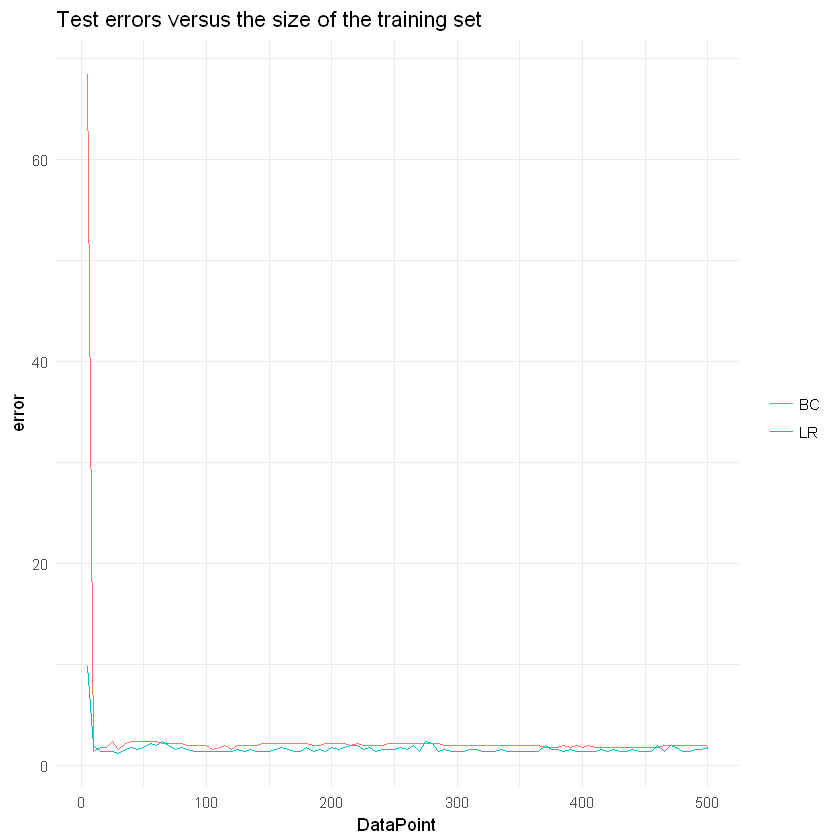

In [8]:
# plot
ggplot(data=test.error.m,aes(x=DataPoint,y=error,color=type)) + geom_line() +
     scale_color_discrete(guide = guide_legend(title = NULL)) + theme_minimal() +
      ggtitle("Test errors versus the size of the training set")

### III. Explain your observations in your Jupyter Notebook file.:

#### a. What does happen for each classifier when the number of training data points is increased?

For Bayes classifier, if the number of training data is relatively small, the testing error will be large. Therefore, when increasing the number of training data, the testing error decreases to a lower level. Then keep increasing the number of training data, the testing error will fluctuate in a small range. Finally it will keep stable no matter how do we inlarge the dataset. 

For Logistic regression, similar with Bayes classifier, if the number of training data is small, the testing error will be large. When enlarging the dataset the testing error decreases significantly; then it will fluctate between a small range.

#### b. Which classifier is best suited when the training set is small, and which is best suited when the training set is big?

From the plot above, we can see:
* When training set is small, the best classifier is Logistic regression.
* When training set is large, Logistic regression performs better.

#### c. Justify your observations in previous questions (III.a & III.b) by providing some speculations and possible reasons.

Question II.a

1. If the training dataset is very small, for example it is only 4, obviously both methods are inaccurate. For Bayesian classifier, estimated parameters of Gussian distributions are not accurrate in terms of few empirical data and for logistic regression, there are less data points for the gradient descent.

2. For a specific training dataset, the Bayesian classifier only has one model, thus for the same testing dataset the testing error always converges to the same value. However, logisitc regression absorbes the advantage of gradient descent to find the optimal parameters, therefore it may fluctuate around the optimal value for long time. But by the constrast, the asymptotic classification accuracy for Logistic Regression is often better than the asymptotic accuracy of Bayesian classifier.

Question III.b

1. Bayesian Classifier uses Bayes Theorem to calculate the postoir probability $p(Y|X)$, while logistic regression directly calculate $p(Y|X)$. Note that the assumption of Bayesian classifier is that each $p(X|Y)$ is independent. If the training set is large, there may be more covariance between features therefore the so $p(X|Y)$ cannot always be independent. By contrast logistic regression will not be impacted by this situation because it uses gradient descent to estimate parameters.

2. If the training dataset is samll, it is bad for logistic regression to estimate parameters while for Bayesian classifier, it performs better.

3. There are D(D+5)/2 + 1 pararmeters for Bayesian classifier while D+1 parameters for logistic regression (D is the dimension of variables). In a large dataset the Batesian classifier is probabily overfitting.